# LLM Interface
The `effectful.handlers.llm` module provides a simplified LLM interface that uses algebraic effects for modularity. The module interface consists of:

- A decorator `Template.define` which creates a prompt template from a callable. A template is an LLM-implemented function whose behavior is specified by a template string. When a template is called, an LLM is invoked to produce the specified behavior.
- A decorator `Tool.define` which exposes Python callables as tools that templates can call. Tool signatures and docstrings define the schema passed to the model.
- Structured output handling via `Encodable` (used internally by templates and tool calls) to serialize/deserialize Python types.
- LLM providers such as `LiteLLMProvider`, and reliability helpers like `RetryLLMHandler` and `ReplayLiteLLMProvider`, which can be composed with `handler(...)` to control execution.

In [ ]:
import base64
import dataclasses
import functools
import io
from typing import Literal

import litellm
import pydantic
from IPython.display import HTML, display
from litellm.caching.caching import Cache
from PIL import Image
from pydantic import field_validator
from pydantic_core import PydanticCustomError

from effectful.handlers.llm import Template, Tool
from effectful.handlers.llm.completions import (
    LiteLLMProvider,
    RetryLLMHandler,
)
from effectful.ops.semantics import NotHandled, handler

provider = LiteLLMProvider()

In the following sections, we walk through each of the mentioned components.

## Prompt Templates

This template function writes (bad) poetry on a given theme. While difficult to implement in Python, an LLM can provide a reasonable implementation.

In [18]:
@Template.define
def limerick(theme: str) -> str:
    """Write a limerick on the theme of {theme}. Do not use any tools."""
    raise NotHandled

If we call the template with a provider interpretation installed, we get reasonable behavior. The LLM is nondeterministic by default, so calling the template twice with the same arguments gives us different results.

Templates are regular callables, so can be converted to operations with `defop` if we want to override the LLM implementation in some cases.

In [19]:
with handler(provider):
    print(limerick("fish"))
    print("-" * 40)
    print(limerick("fish"))

In the ocean so deep and so wide,
There's a fish with a fin full of pride.
He swims with a gleam,
In a school like a dream,
As they wander the blue, side by side.
----------------------------------------
In the depths of the sea, fish frolic with glee,
From goldfish to salmon, they're ever so free.
They swim and they dart,
Each plays its own part,
Underneath waves, they carelessly spree.


If we want deterministic behavior, we can cache the template call. We can either cache it with the default `@functools.cache` or use LiteLLM's built-in cache by setting a cache backend and passing `caching=True` to the provider:

In [20]:
@functools.cache
@Template.define
def haiku(theme: str) -> str:
    """Write a haiku on the theme of {theme}. Do not use any tools."""
    raise NotHandled


@Template.define
def haiku_no_cache(theme: str) -> str:
    """Write a haiku on the theme of {theme}. Do not use any tools."""
    raise NotHandled


print()
with handler(provider):
    print(haiku("fish"))
    print("-" * 40)
    print(haiku("fish"))

print()
# Enable LiteLLM caching by setting a cache backend and enabling caching.
litellm.cache = Cache()
provider_cached = LiteLLMProvider(caching=True)
try:
    with handler(provider_cached):
        print(haiku_no_cache("fish2"))
        print("-" * 40)
        print(haiku_no_cache("fish2"))
finally:
    litellm.cache = None

print()
with handler(provider):
    print(haiku_no_cache("fish3"))
    print("-" * 40)
    print(haiku_no_cache("fish3"))


Swim in silent streams,
Scales gleam under moonlit glow—
River's whispered dreams.
----------------------------------------
Swim in silent streams,
Scales gleam under moonlit glow—
River's whispered dreams.

Silver scales glisten,
Beneath the ocean's whisper—  
Silent fins dance deep.
----------------------------------------
In ocean's vast depth,  
Gliding through the watery world,  
Fish dance with the waves.

Fish swim with grace, free—
In vast blue ocean they glide,
Silent in their world.
----------------------------------------
In tranquil waters,
Silver scales shimmer and dart—
Silent fish dance swift.


## Converting LLM Results to Python Objects

Type conversion is handled by `decode`. By default, primitive types are converted. `DecodeError` is raised if a response cannot be converted.

In [21]:
@Template.define
def primes(first_digit: int) -> int:
    """Give a prime number with {first_digit} as the first digit. Do not use any tools."""
    raise NotHandled


with handler(provider):
    assert type(primes(6)) is int

More complex types can be converted by providing handlers for `decode`. Callable synthesis is supported via `Encodable` and the evaluation providers in `effectful.handlers.llm.evaluation` (`UnsafeEvalProvider` or `RestrictedEvalProvider`), which enable parsing/compiling/executing synthesized code.

In [22]:
import inspect
from collections.abc import Callable

from effectful.handlers.llm.evaluation import UnsafeEvalProvider


@Template.define
def count_char(char: str) -> Callable[[str], int]:
    """Write a function which takes a string and counts the occurrances of '{char}'. Do not use any tools."""
    raise NotHandled


# Use UnsafeEvalProvider for simple examples; RestrictedEvalProvider may need extra globals.
with handler(provider), handler(UnsafeEvalProvider()):
    count_a = count_char("a")
    assert callable(count_a)
    assert count_a("banana") == 3
    assert count_a("cherry") == 0
    # Print the source code of the generated function
    print(inspect.getsource(count_a))

def count_a_occurrences(input_string: str) -> int:
    """
    Count the occurrences of the letter 'a' in a given string.

    :param input_string: The string to search within.
    :return: The number of times 'a' appears in the string.
    """
    return input_string.count('a')


## Tool Calling

`Operation`s defined in the lexical scope of a `Template` are automatically available for the LLM to call as tools. The description of these operations is inferred from their type annotations and docstrings.

Tool calls are mediated by a helper operation `tool_call`. Handling this operation allows tool use to be tracked or logged.

In [23]:
@Tool.define
def cities() -> list[str]:
    """Return a list of cities that can be passed to `weather`."""
    return ["Chicago", "New York", "Barcelona"]


@Tool.define
def weather(city: str) -> str:
    """Given a city name, return a description of the weather in that city."""
    status = {"Chicago": "cold", "New York": "wet", "Barcelona": "sunny"}
    return status.get(city, "unknown")


@Template.define  # cities and weather auto-captured from lexical scope
def vacation() -> str:
    """Use the provided tools to suggest a city that has good weather. Use only the `cities` and `weather` tools provided."""
    raise NotHandled


with handler(provider):
    print(vacation())

Based on the weather conditions:

- **Chicago** is currently cold.
- **New York** is currently wet.
- **Barcelona** is currently sunny.

I suggest **Barcelona** as the city with good weather.


## Image Inputs

You can pass `PIL.Image.Image` values directly to templates.


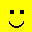

A simple smiley face with a yellow background, featuring two black dots for eyes and a curved line for a mouth, typically used to convey happiness or friendliness.


In [24]:
image_base64 = (
    "iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAYAAABzenr0AAAAhElEQVR4nO2W4QqA"
    "MAiEVXr/VzYWDGoMdk7Cgrt/sUs/DqZTd3EplFU2JwATYAJMoOlAB4bq89s95+Mg"
    "+gyAchsKAYplBBBA43hFhfxnUixDjdEUUL8hpr7R0KLdt9qElzcyiu8As+Kr8zQA"
    "mgLavAl+kIzFZyCRxtsAmWb/voZvqRzgBE1sIDuVFX4eAAAAAElFTkSuQmCC"
)
image = Image.open(io.BytesIO(base64.b64decode(image_base64)))


@Template.define
def describe_image(image: Image.Image) -> str:
    """Return a short description of the following image.
    {image}
    """
    raise NotHandled


with handler(provider):
    display(
        HTML(
            f'<img src="data:image/png;base64,{image_base64}" alt="Example image" width="320" />'
        )
    )
    print(describe_image(image))

## Structured Output Generation

Constrained generation is used for any type that is convertible to a Pydantic model.

In [25]:
@dataclasses.dataclass
class KnockKnockJoke:
    whos_there: str
    punchline: str


@Template.define
def write_joke(theme: str) -> KnockKnockJoke:
    """Write a knock-knock joke on the theme of {theme}. Do not use any tools."""
    raise NotHandled


@Template.define
def rate_joke(joke: KnockKnockJoke) -> bool:
    """Decide if {joke} is funny or not. Do not use any tools."""
    raise NotHandled


def do_comedy():
    joke = write_joke("lizards")
    print("> You are onstage at a comedy club. You tell the following joke:")
    print(
        f"Knock knock.\nWho's there?\n{joke.whos_there}.\n{joke.whos_there} who?\n{joke.punchline}"
    )
    if rate_joke(joke):
        print("> The crowd laughs politely.")
    else:
        print("> The crowd stares in stony silence.")


with handler(provider):
    do_comedy()

> You are onstage at a comedy club. You tell the following joke:
Knock knock.
Who's there?
Lizard.
Lizard who?
Lizard who? Lizard you wonder, there's a gecko at your door!
> The crowd laughs politely.


## Template Composition

Templates defined in the lexical scope are also captured, enabling template composition. One template can use the result of another template in a pipeline:


In [26]:
# Sub-templates for different story styles
@Template.define
def story_with_moral(topic: str) -> str:
    """Write a short story about {topic} and end with a moral lesson. Do not use any tools."""
    raise NotHandled


@Template.define
def story_funny(topic: str) -> str:
    """Write a funny, humorous story about {topic}. Do not use any tools."""
    raise NotHandled


# Main orchestrator template - has access to sub-templates
@Template.define
def write_story(topic: str, style: str) -> str:
    """Write a story about {topic} in the style: {style}.
    Available styles: 'moral' for a story with a lesson, 'funny' for humor. Use story_funny for humor, story_with_moral for a story with a lesson."""
    raise NotHandled


# Verify sub-templates are captured in write_story's lexical context
assert story_with_moral in write_story.tools.values()
assert story_funny in write_story.tools.values()
print("Sub-templates available to write_story:", write_story.tools.keys())

with handler(provider):
    print("=== Story with moral ===")
    print(write_story("a curious cat", "moral"))
    print()
    print("=== Funny story ===")
    print(write_story("a curious cat", "funny"))

Sub-templates available to write_story: dict_keys(['describe_image', 'draw_simple_icon', 'limerick', 'haiku_no_cache', 'primes', 'count_char', 'cities', 'weather', 'vacation', 'write_joke', 'rate_joke', 'story_with_moral', 'story_funny'])
=== Story with moral ===


In the case of Whiskers, it was his understanding of this balance that brought him safely home, with both stories and lessons to cherish and share.

=== Funny story ===


The End.


## Retrying LLM Requests
LLM calls can sometimes fail due to transient errors or produce invalid outputs. The `RetryLLMHandler` automatically retries failed template calls and can also surface tool/runtime errors as tool messages:

- `num_retries`: Maximum number of retry attempts (default: 3)
- `include_traceback`: When `True`, include traceback details in the error feedback (default: False)
- `catch_tool_errors`: Exception type(s) to catch during tool execution (default: `Exception`)


Example usage: having an unstable service that seldomly fail.

In [27]:
call_count = 0
REQUIRED_RETRIES = 3


@Tool.define
def unstable_service() -> str:
    """Fetch data from an unstable external service. May require retries."""
    global call_count
    call_count += 1
    if call_count < REQUIRED_RETRIES:
        raise ConnectionError(
            f"Service unavailable! Attempt {call_count}/{REQUIRED_RETRIES}. Please retry."
        )
    return "{ 'status': 'ok', 'data': [1, 2, 3] }"


@Template.define  # unstable_service auto-captured from lexical scope
def fetch_data() -> str:
    """Use the unstable_service tool to fetch data."""
    raise NotHandled


with handler(provider):
    try:
        result = fetch_data()
    except Exception as e:
        print(f"Error: {e}")

with handler(provider), handler(RetryLLMHandler(num_retries=3)):
    result = fetch_data()
    print(f"Result: {result}", "Retries:", call_count)

Error: Service unavailable! Attempt 1/3. Please retry.
Result: The data fetched from the unstable service is: `[1, 2, 3]`. Retries: 3


## Retrying with Validation Errors
As noted above, the `RetryHandler` can also be used to retry on runtime/validation error:

In [28]:
@pydantic.dataclasses.dataclass
class Rating:
    score: int
    explanation: str

    @field_validator("score")
    @classmethod
    def check_score(cls, v):
        if v < 1 or v > 5:
            raise PydanticCustomError(
                "invalid_score",
                "score must be 1–5, got {v}",
                {"v": v},
            )
        return v

    @field_validator("explanation")
    @classmethod
    def check_explanation_contains_score(cls, v, info):
        score = info.data.get("score", None)
        if score is not None and str(score) not in v:
            raise PydanticCustomError(
                "invalid_explanation",
                "explanation must mention the score {score}, got '{explanation}'",
                {"score": score, "explanation": v},
            )
        return v


@Template.define
def give_rating_for_movie(movie_name: str) -> Rating:
    """Give a rating for {movie_name}. The explanation MUST include the numeric score. Do not use any tools."""
    raise NotHandled


with handler(provider):
    try:
        rating = give_rating_for_movie("Die Hard")
    except Exception as e:
        print(f"Error: {e}")

with handler(provider), handler(RetryLLMHandler(num_retries=3)):
    rating = give_rating_for_movie("Die Hard")
    print(f"Score: {rating.score}/5")
    print(f"Explanation: {rating.explanation}")

Error: Error decoding response: 1 validation error for Response
value.score
  score must be 1–5, got 9 [type=invalid_score, input_value=9, input_type=int]. Please provide a valid response and try again.
Score: 5/5
Explanation: Die Hard is widely acclaimed as one of the best action films of all time and earns a perfect score of 5 out of 5. Its success is attributed to a gripping storyline, memorable performances, particularly by Bruce Willis as John McClane, and its innovative approach to action sequences. Its mix of humor, suspense, and holiday-themed backdrop makes it a perennial favorite, cementing its status as a cultural icon.


## Generating higher-order functions
Finally, we can generate higher-order functions that can call templates as well:

In [29]:
# Sub-templates for different story styles
@Template.define
def write_chapter(chapter_number: int, chapter_name: str) -> str:
    """Write a short story about {chapter_number}. Do not use any tools."""
    raise NotHandled


@Template.define
def judge_chapter(story_so_far: str, chapter_number: int) -> bool:
    """Decide if the new chapter is coherence with the story so far. Do not use any tools."""
    raise NotHandled


# Main orchestrator template - has access to sub-templates
@Template.define
def write_multi_chapter_story(style: Literal["moral", "funny"]) -> Callable[[str], str]:
    """Generate a function that writes a story in style: {style} about the given topic.

    The program can use helper functions defined elsewhere (DO NOT REDEFINE THEM):
    - write_chapter(chapter_number: int, chapter_name: str) -> str
    - judge_chapter(story_so_far: str, chapter_number: int) -> bool"""
    raise NotHandled


# Verify sub-templates are captured in write_story's lexical context
print("Sub-templates available to write_story:", write_multi_chapter_story.tools.keys())

with (
    handler(RetryLLMHandler(num_retries=3)),
    handler(provider),
    handler(UnsafeEvalProvider()),
):
    print("=== Story with moral ===")
    function_that_writes_story = write_multi_chapter_story("moral")
    print(inspect.getsource(function_that_writes_story))
    print(function_that_writes_story("a curious cat"))
    print()

Sub-templates available to write_story: dict_keys(['describe_image', 'draw_simple_icon', 'limerick', 'haiku_no_cache', 'primes', 'count_char', 'cities', 'weather', 'vacation', 'write_joke', 'rate_joke', 'story_with_moral', 'story_funny', 'write_story', 'unstable_service', 'fetch_data', 'give_rating_for_movie', 'write_chapter', 'judge_chapter'])
=== Story with moral ===
def create_moral_story(topic: str) -> str:
    # Start with an introduction and establish the story theme
    chapter_1 = write_chapter(1, f"Introduction to {topic}")
    
    # Develop the plot with a challenge or situation related to the topic
    chapter_2 = write_chapter(2, f"The Challenge of {topic}")
    
    # Introduce a turning point or decision-making moment involving the topic
    chapter_3 = write_chapter(3, f"Decisions and Consequences of {topic}")
    
    # Conclusion wrapping up the story and highlighting the moral
    chapter_4 = write_chapter(4, f"Moral and Lessons of {topic}")
    
    # Combine all ch